In [8]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor

SAMPLE_RATE = 16000
TARGET_LENGTH = 5 * SAMPLE_RATE  # 5 seconds

def load_and_preprocess(filename, augment=False):
    wav, _ = librosa.load(filename, sr=SAMPLE_RATE, mono=True)
    wav = librosa.util.normalize(wav)  # Normalize amplitude

    # Padding or truncation
    if len(wav) < TARGET_LENGTH:
        wav = np.pad(wav, (0, TARGET_LENGTH - len(wav)), 'constant')
    else:
        wav = wav[:TARGET_LENGTH]

    if augment:
        wav = apply_augmentations(wav)

    # Padding or truncation
    if len(wav) < TARGET_LENGTH:
        wav = np.pad(wav, (0, TARGET_LENGTH - len(wav)), 'constant')
    else:
        wav = wav[:TARGET_LENGTH]

    return wav

def apply_augmentations(wav):
    """Applies data augmentation techniques"""
    # Time Stretching (random rate between 0.8x and 1.2x)
    if np.random.rand() < 0.5:  
        rate = np.random.uniform(0.8, 1.2)
        wav = librosa.effects.time_stretch(wav, rate=rate)

    # Time Shifting (random shift up to 0.5 sec)
    if np.random.rand() < 0.5:
        shift = np.random.randint(0, int(0.5 * SAMPLE_RATE))  # Max shift = 0.5 sec
        wav = np.roll(wav, shift)

    # Pitch Shifting (random pitch shift of ±2 semitones)
    if np.random.rand() < 0.5:
        semitones = np.random.uniform(-2, 2)
        wav = librosa.effects.pitch_shift(wav, sr=SAMPLE_RATE, n_steps=semitones)

    # Background Noise Addition (random noise at 5-10% of signal amplitude)
    if np.random.rand() < 0.5:
        noise = np.random.randn(len(wav)) * 0.05  # 5% noise level
        wav = wav + noise

    # Dynamic Range Compression (DRC)
    if np.random.rand() < 0.5:
        wav = librosa.effects.percussive(wav)  # Simulates DRC by reducing background energy

    return wav

def process_dataset_parallel(file_paths, augment=False):
    """Loads and preprocesses audio files in parallel"""
    with ThreadPoolExecutor(max_workers=8) as executor:
        processed_wavs = list(executor.map(lambda f: load_and_preprocess(f, augment), file_paths))
    return processed_wavs

import torch

def load_dataset(base_dir, augment=False):
    file_paths, labels = [], []
    label_map = {"cry": 0, "scream": 1, "speech": 2}

    for subdir, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".wav"):
                file_paths.append(os.path.join(subdir, file))
                labels.append(label_map[os.path.basename(subdir)])

    # Load and preprocess in parallel
    audio_data = process_dataset_parallel(file_paths, augment=augment)

    # Stack list of arrays and convert to PyTorch tensors
    data_tensor = torch.tensor(np.stack(audio_data), dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.int64)

    # Create and return a PyTorch dataset
    dataset = torch.utils.data.TensorDataset(data_tensor, labels_tensor)
    return dataset

In [9]:
# Load the dataset
dataset = load_dataset("data", augment=True)

In [10]:
# Split the dataset into train, validation, and test sets taking care of stratification
train_size = int(0.72 * len(dataset))
val_size = int(0.18 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

In [6]:
train_dataset[0], train_dataset[0][0].shape

((tensor([ 4.5724e-04,  4.5922e-04,  7.6810e-04,  ..., -3.2593e-04,
          -2.3459e-04, -2.9297e-05]),
  tensor(1)),
 torch.Size([80000]))

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import (
    Wav2Vec2ForSequenceClassification,
    Wav2Vec2Processor,
    Trainer,
    TrainingArguments
)

# Load the processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=3)

# Define the data collator
def data_collator(batch):
    input_values = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch])
    input_values_padded = torch.nn.utils.rnn.pad_sequence(input_values, batch_first=True)
    return {"input_values": input_values_padded, "labels": labels}

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=data_collator)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=data_collator)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=1,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss"
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
)

# Fine-tune the model
trainer.train()

/home/pinakinc/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/pinakinc/miniforge3/lib/python3.12/site-packages/transformers/configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/h

Epoch,Training Loss,Validation Loss
1,1.083000,1.077816
2,1.055700,1.063676
3,1.005300,1.014180
4,0.978100,1.026374
5,0.874600,0.902249
6,0.792700,0.849406
7,0.678200,0.863159
8,0.581300,0.792329
9,0.488200,0.690895
10,0.362600,0.702230


TrainOutput(global_step=720, training_loss=0.49756955256064733, metrics={'train_runtime': 733.521, 'train_samples_per_second': 7.771, 'train_steps_per_second': 0.982, 'total_flos': 2.58741733392e+17, 'train_loss': 0.49756955256064733, 'epoch': 20.0})

In [7]:
from sklearn.metrics import precision_score, accuracy_score, f1_score, confusion_matrix
import numpy as np

from transformers import Wav2Vec2ForSequenceClassification

# Load the best model weights
best_model = Wav2Vec2ForSequenceClassification.from_pretrained("./results/checkpoint-468")

# Initialize the Trainer with the best model
trainer = Trainer(
    model=best_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
)

# Evaluate the model on the test dataset
predictions = trainer.predict(test_dataset)

# Get the predicted labels and true labels
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Compute metrics
precision = precision_score(labels, preds, average='weighted')
accuracy = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average='weighted')
conf_matrix = confusion_matrix(labels, preds)

# Print the metrics
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Precision: 0.7483
Accuracy: 0.7000
F1 Score: 0.7031
Confusion Matrix:
[[18  1  0]
 [ 1  4  2]
 [ 1  7  6]]


In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor

SAMPLE_RATE = 16000
TARGET_LENGTH = 5 * SAMPLE_RATE  # 5 seconds

def load_and_preprocess(filename, augment=False):
    wav, _ = librosa.load(filename, sr=SAMPLE_RATE, mono=True)
    wav = librosa.util.normalize(wav)  # Normalize amplitude

    # Padding or truncation
    if len(wav) < TARGET_LENGTH:
        wav = np.pad(wav, (0, TARGET_LENGTH - len(wav)), 'constant')
    else:
        wav = wav[:TARGET_LENGTH]

    if augment:
        wav = apply_augmentations(wav)

    # Padding or truncation
    if len(wav) < TARGET_LENGTH:
        wav = np.pad(wav, (0, TARGET_LENGTH - len(wav)), 'constant')
    else:
        wav = wav[:TARGET_LENGTH]

    return wav

def apply_augmentations(wav):
    """Applies data augmentation techniques"""
    # Time Stretching (random rate between 0.8x and 1.2x)
    if np.random.rand() < 0.5:  
        rate = np.random.uniform(0.8, 1.2)
        wav = librosa.effects.time_stretch(wav, rate=rate)

    # Time Shifting (random shift up to 0.5 sec)
    if np.random.rand() < 0.5:
        shift = np.random.randint(0, int(0.5 * SAMPLE_RATE))  # Max shift = 0.5 sec
        wav = np.roll(wav, shift)

    # Pitch Shifting (random pitch shift of ±2 semitones)
    if np.random.rand() < 0.5:
        semitones = np.random.uniform(-2, 2)
        wav = librosa.effects.pitch_shift(wav, sr=SAMPLE_RATE, n_steps=semitones)

    # Background Noise Addition (random noise at 5-10% of signal amplitude)
    if np.random.rand() < 0.5:
        noise = np.random.randn(len(wav)) * 0.05  # 5% noise level
        wav = wav + noise

    # Dynamic Range Compression (DRC)
    if np.random.rand() < 0.5:
        wav = librosa.effects.percussive(wav)  # Simulates DRC by reducing background energy

    return wav

def process_dataset_parallel(file_paths, augment=False):
    """Loads and preprocesses audio files in parallel"""
    with ThreadPoolExecutor(max_workers=8) as executor:
        processed_wavs = list(executor.map(lambda f: load_and_preprocess(f, augment), file_paths))
    return processed_wavs

import torch

def load_dataset(base_dir, augment=False):
    file_paths, labels = [], []
    label_map = {"cry": 0, "scream": 1, "speech": 2}

    for subdir, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".wav"):
                file_paths.append(os.path.join(subdir, file))
                labels.append(label_map[os.path.basename(subdir)])

    # Load and preprocess in parallel
    audio_data = process_dataset_parallel(file_paths, augment=augment)

    # Stack list of arrays and convert to PyTorch tensors
    data_tensor = torch.tensor(np.stack(audio_data), dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.int64)

    # Create and return a PyTorch dataset
    dataset = torch.utils.data.TensorDataset(data_tensor, labels_tensor)
    return dataset

2025-02-23 13:07:26.312263: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-23 13:07:26.320126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740296246.329068 3020198 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740296246.331730 3020198 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-23 13:07:26.341245: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Load the dataset
dataset = load_dataset("data", augment=True)

In [3]:
# Split the dataset into train, validation, and test sets taking care of stratification
train_size = int(0.72 * len(dataset))
val_size = int(0.18 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

In [4]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

# Load the processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
wav2vec2_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")

# Define the data collator
def data_collator(batch):
    input_values = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch])
    input_values_padded = torch.nn.utils.rnn.pad_sequence(input_values, batch_first=True)
    return {"input_values": input_values_padded, "labels": labels}

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=data_collator)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=data_collator)

# Extract embeddings
def extract_embeddings(dataloader):
    embeddings = []
    labels = []
    wav2vec2_model.eval()
    with torch.no_grad():
        for batch in dataloader:
            input_values = batch["input_values"]
            label = batch["labels"]
            outputs = wav2vec2_model(input_values).last_hidden_state.mean(dim=1)  # Mean pooling
            embeddings.append(outputs)
            labels.append(label)
    return torch.cat(embeddings), torch.cat(labels)

train_embeddings, train_labels = extract_embeddings(train_loader)
val_embeddings, val_labels = extract_embeddings(val_loader)
test_embeddings, test_labels = extract_embeddings(test_loader)

# Create TensorDatasets for embeddings
train_dataset = TensorDataset(train_embeddings, train_labels)
val_dataset = TensorDataset(val_embeddings, val_labels)
test_dataset = TensorDataset(test_embeddings, test_labels)

/home/pinakinc/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/pinakinc/miniforge3/lib/python3.12/site-packages/transformers/configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Validation Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 5751.75it/s]


Epoch 1/40, Train Loss: 0.137613694709644, Train Accuracy: 0.43859649122807015, Validation Loss: 0.1387349887632988, Validation Accuracy: 0.38028169014084506


Validation Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 4340.43it/s]


Epoch 2/40, Train Loss: 0.1353290829742164, Train Accuracy: 0.43157894736842106, Validation Loss: 0.1383184127404656, Validation Accuracy: 0.3380281690140845


Validation Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 6090.47it/s]


Epoch 3/40, Train Loss: 0.13326906133116337, Train Accuracy: 0.44912280701754387, Validation Loss: 0.13801038768929494, Validation Accuracy: 0.30985915492957744


Validation Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 6387.26it/s]


Epoch 4/40, Train Loss: 0.1313614859915616, Train Accuracy: 0.5263157894736842, Validation Loss: 0.13631603583483629, Validation Accuracy: 0.38028169014084506


Validation Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 3461.28it/s]


Epoch 5/40, Train Loss: 0.1295450166652077, Train Accuracy: 0.5473684210526316, Validation Loss: 0.1357431688778837, Validation Accuracy: 0.352112676056338


Validation Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 6141.00it/s]


Epoch 6/40, Train Loss: 0.12759112642522444, Train Accuracy: 0.5333333333333333, Validation Loss: 0.13513111564475047, Validation Accuracy: 0.36619718309859156


Validation Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 3434.20it/s]


Epoch 7/40, Train Loss: 0.1259805863363701, Train Accuracy: 0.5614035087719298, Validation Loss: 0.13397398800917074, Validation Accuracy: 0.39436619718309857


Validation Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 3496.22it/s]


Epoch 8/40, Train Loss: 0.12437162022841604, Train Accuracy: 0.6140350877192983, Validation Loss: 0.13304909434117063, Validation Accuracy: 0.4507042253521127


Validation Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 3497.52it/s]


Epoch 9/40, Train Loss: 0.12276804238034968, Train Accuracy: 0.6175438596491228, Validation Loss: 0.13192518664077973, Validation Accuracy: 0.4788732394366197


Validation Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 6246.69it/s]


Epoch 10/40, Train Loss: 0.12140254137808816, Train Accuracy: 0.6280701754385964, Validation Loss: 0.13125305696272513, Validation Accuracy: 0.49295774647887325


Validation Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 5546.39it/s]


Epoch 11/40, Train Loss: 0.11954563186879744, Train Accuracy: 0.6070175438596491, Validation Loss: 0.13110948448449794, Validation Accuracy: 0.4647887323943662


Validation Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 7134.52it/s]


Epoch 12/40, Train Loss: 0.11834054913437157, Train Accuracy: 0.6350877192982456, Validation Loss: 0.12995146277924657, Validation Accuracy: 0.49295774647887325


Validation Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 8071.14it/s]


Epoch 13/40, Train Loss: 0.1166134144130506, Train Accuracy: 0.6385964912280702, Validation Loss: 0.12907784757479815, Validation Accuracy: 0.5211267605633803


Validation Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 7472.04it/s]


Epoch 14/40, Train Loss: 0.11587214532651399, Train Accuracy: 0.6701754385964912, Validation Loss: 0.12855571760258205, Validation Accuracy: 0.5211267605633803


Validation Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 7638.35it/s]


Epoch 15/40, Train Loss: 0.11418774441668862, Train Accuracy: 0.6701754385964912, Validation Loss: 0.12696608942998966, Validation Accuracy: 0.5352112676056338


Validation Epoch 16: 100%|██████████| 9/9 [00:00<00:00, 7950.45it/s]


Epoch 16/40, Train Loss: 0.11286589471917403, Train Accuracy: 0.6877192982456141, Validation Loss: 0.1265508238698395, Validation Accuracy: 0.5211267605633803


Validation Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 6111.18it/s]


Epoch 17/40, Train Loss: 0.11142107373789738, Train Accuracy: 0.6701754385964912, Validation Loss: 0.12602320691229593, Validation Accuracy: 0.5211267605633803


Validation Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 3426.10it/s]


Epoch 18/40, Train Loss: 0.11004900451292071, Train Accuracy: 0.6771929824561403, Validation Loss: 0.1246822308486616, Validation Accuracy: 0.5211267605633803


Validation Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 3581.81it/s]


Epoch 19/40, Train Loss: 0.10860644097913776, Train Accuracy: 0.6912280701754386, Validation Loss: 0.12415299952869684, Validation Accuracy: 0.5211267605633803


Validation Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 7467.60it/s]


Epoch 20/40, Train Loss: 0.10735890175166883, Train Accuracy: 0.7052631578947368, Validation Loss: 0.12426603092274195, Validation Accuracy: 0.5211267605633803


Validation Epoch 21: 100%|██████████| 9/9 [00:00<00:00, 7838.19it/s]


Epoch 21/40, Train Loss: 0.10613008967617102, Train Accuracy: 0.6947368421052632, Validation Loss: 0.12319320608192766, Validation Accuracy: 0.5211267605633803


Validation Epoch 22: 100%|██████████| 9/9 [00:00<00:00, 7759.25it/s]


Epoch 22/40, Train Loss: 0.1051644904571667, Train Accuracy: 0.7052631578947368, Validation Loss: 0.12222382132436188, Validation Accuracy: 0.5211267605633803


Validation Epoch 23: 100%|██████████| 9/9 [00:00<00:00, 7678.75it/s]


Epoch 23/40, Train Loss: 0.10386389828564828, Train Accuracy: 0.7052631578947368, Validation Loss: 0.12163309648003377, Validation Accuracy: 0.5211267605633803


Validation Epoch 24: 100%|██████████| 9/9 [00:00<00:00, 7928.74it/s]


Epoch 24/40, Train Loss: 0.10273263266212061, Train Accuracy: 0.7157894736842105, Validation Loss: 0.121613923092963, Validation Accuracy: 0.5211267605633803


Validation Epoch 25: 100%|██████████| 9/9 [00:00<00:00, 7872.52it/s]


Epoch 25/40, Train Loss: 0.10185226557547586, Train Accuracy: 0.7087719298245614, Validation Loss: 0.1205515399785109, Validation Accuracy: 0.5211267605633803


Validation Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 7875.81it/s]


Epoch 26/40, Train Loss: 0.10110240505452742, Train Accuracy: 0.712280701754386, Validation Loss: 0.11971842487093429, Validation Accuracy: 0.5211267605633803


Validation Epoch 27: 100%|██████████| 9/9 [00:00<00:00, 7854.50it/s]


Epoch 27/40, Train Loss: 0.09982104866128219, Train Accuracy: 0.7228070175438597, Validation Loss: 0.1196741671629355, Validation Accuracy: 0.5211267605633803


Validation Epoch 28: 100%|██████████| 9/9 [00:00<00:00, 7913.78it/s]


Epoch 28/40, Train Loss: 0.0987420257769133, Train Accuracy: 0.7157894736842105, Validation Loss: 0.11874009018212976, Validation Accuracy: 0.5352112676056338


Validation Epoch 29: 100%|██████████| 9/9 [00:00<00:00, 7573.98it/s]


Epoch 29/40, Train Loss: 0.09790436384970681, Train Accuracy: 0.7228070175438597, Validation Loss: 0.11875113802896418, Validation Accuracy: 0.5352112676056338


Validation Epoch 30: 100%|██████████| 9/9 [00:00<00:00, 7841.45it/s]


Epoch 30/40, Train Loss: 0.09682893585740474, Train Accuracy: 0.7192982456140351, Validation Loss: 0.11843001758548576, Validation Accuracy: 0.5211267605633803


Validation Epoch 31: 100%|██████████| 9/9 [00:00<00:00, 7841.45it/s]


Epoch 31/40, Train Loss: 0.09583383213009751, Train Accuracy: 0.7333333333333333, Validation Loss: 0.1172209919338495, Validation Accuracy: 0.5352112676056338


Validation Epoch 32: 100%|██████████| 9/9 [00:00<00:00, 7999.31it/s]


Epoch 32/40, Train Loss: 0.09509606424130891, Train Accuracy: 0.7368421052631579, Validation Loss: 0.11713452658183138, Validation Accuracy: 0.5352112676056338


Validation Epoch 33: 100%|██████████| 9/9 [00:00<00:00, 6101.30it/s]


Epoch 33/40, Train Loss: 0.09428498117547286, Train Accuracy: 0.743859649122807, Validation Loss: 0.11708649027515465, Validation Accuracy: 0.5211267605633803


Validation Epoch 34: 100%|██████████| 9/9 [00:00<00:00, 3418.65it/s]


Epoch 34/40, Train Loss: 0.0935172668674536, Train Accuracy: 0.7263157894736842, Validation Loss: 0.11761124285174088, Validation Accuracy: 0.5352112676056338


Validation Epoch 35: 100%|██████████| 9/9 [00:00<00:00, 7186.13it/s]


Epoch 35/40, Train Loss: 0.09224819373666195, Train Accuracy: 0.7403508771929824, Validation Loss: 0.11546883868499541, Validation Accuracy: 0.5211267605633803


Validation Epoch 36: 100%|██████████| 9/9 [00:00<00:00, 6451.67it/s]


Epoch 36/40, Train Loss: 0.09249682823816935, Train Accuracy: 0.7403508771929824, Validation Loss: 0.11571414034131547, Validation Accuracy: 0.5352112676056338


Validation Epoch 37: 100%|██████████| 9/9 [00:00<00:00, 3416.79it/s]


Epoch 37/40, Train Loss: 0.09068438578070256, Train Accuracy: 0.7368421052631579, Validation Loss: 0.11493788638585051, Validation Accuracy: 0.5070422535211268


Validation Epoch 38: 100%|██████████| 9/9 [00:00<00:00, 6264.31it/s]


Epoch 38/40, Train Loss: 0.09042271323371352, Train Accuracy: 0.7403508771929824, Validation Loss: 0.11478543533405787, Validation Accuracy: 0.5070422535211268


Validation Epoch 39: 100%|██████████| 9/9 [00:00<00:00, 6403.52it/s]


Epoch 39/40, Train Loss: 0.08898749989375733, Train Accuracy: 0.7508771929824561, Validation Loss: 0.1138011460572901, Validation Accuracy: 0.5070422535211268


Validation Epoch 40: 100%|██████████| 9/9 [00:00<00:00, 7818.71it/s]


Epoch 40/40, Train Loss: 0.08927963710667794, Train Accuracy: 0.7403508771929824, Validation Loss: 0.11493499262232176, Validation Accuracy: 0.5211267605633803


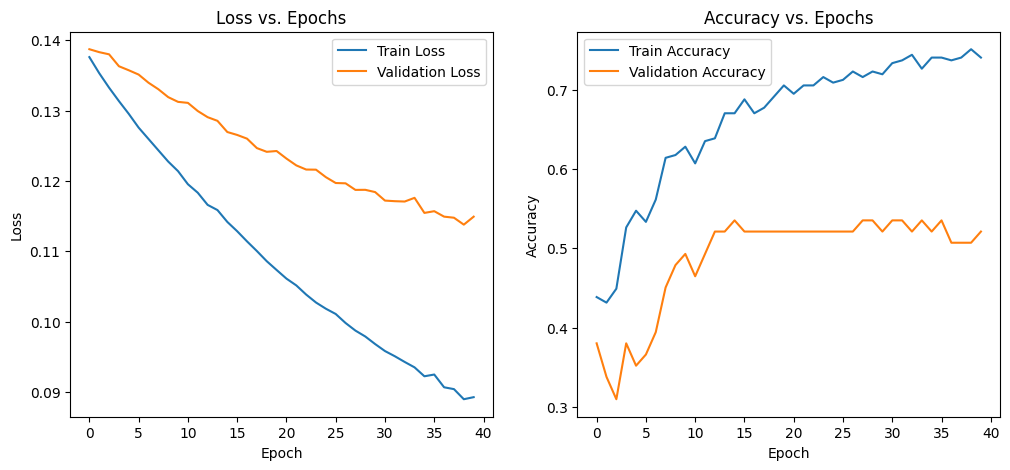

In [5]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        x = self.model(x)
        return x

mlp_model = MLP(input_dim=train_embeddings.shape[1], output_dim=3)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=3e-5)

# Variables to store losses and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0
best_model_state = None

# Train the MLP model
num_epochs = 40
for epoch in range(num_epochs):
    mlp_model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, labels in tqdm(DataLoader(train_dataset, batch_size=8, shuffle=True), desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()
        outputs = mlp_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
    train_losses.append(train_loss / len(train_dataset))
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation
    mlp_model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in tqdm(DataLoader(val_dataset, batch_size=8, shuffle=False), desc=f"Validation Epoch {epoch+1}"):
            outputs = mlp_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()
    val_losses.append(val_loss / len(val_dataset))
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = mlp_model.state_dict()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_dataset)}, Train Accuracy: {train_accuracy}, Validation Loss: {val_loss/len(val_dataset)}, Validation Accuracy: {val_accuracy}")

# Save the best model
torch.save(best_model_state, "best_mlp_model.pth")

# Plot the losses and accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.show()

In [6]:
# evaluate on test set: precision, accuracy, f1 score, confusion matrix
from sklearn.metrics import precision_score, accuracy_score, f1_score, confusion_matrix
import numpy as np

# Get predictions by best model from file
best_model = MLP(input_dim=test_embeddings.shape[1], output_dim=3)
best_model.load_state_dict(torch.load("best_mlp_model.pth"))
best_model.eval()

# Get predictions
preds = []
with torch.no_grad():
    for inputs, labels in DataLoader(test_dataset, batch_size=8, shuffle=False):
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        preds.extend(predicted.tolist())

# Compute metrics
precision = precision_score(test_labels, preds, average='weighted')
accuracy = accuracy_score(test_labels, preds)
f1 = f1_score(test_labels, preds, average='weighted')
conf_matrix = confusion_matrix(test_labels, preds)

# Print the metrics
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Precision: 0.7181
Accuracy: 0.7250
F1 Score: 0.7173
Confusion Matrix:
[[19  0  0]
 [ 0  3  4]
 [ 2  5  7]]
